`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022`   

Выполнил: Кечин Дмитрий ПМИ 3-1




# Лабораторная работа №3: Линейные модели. Кросс-валидация. 

Ниже показана домашняя работа.
Задания: 
1. Данные своего варианта (см. таблицу ниже) разделить на выборку для построения моделей (80%) и отложенные наблюдения (20%). Оставить в таблице только указанные в варианте переменные. Отложенные наблюдения использовать только в задании 6.
2. Провести предварительный анализ данных с помощью описательных статистик и графиков из этой лабораторной.
3. Прологарифмировать на нормальность. Если он распределён не по нормальному закону, прологарифмировать и снова провести анализ взаимосвязей переменных.
4. Составить список возможных спецификаций моделей множественной регрессии (на исходной и на логарифме ).
5. Оценить параметры моделей из списка. Оценить точность моделей методом перекрёстной проверки, указанным в варианте. Найти самую точную из моделей для . Найти самую точную из моделей для .
6. Сделать прогноз с помощью самых точных моделей на отложенные наблюдения. Рассчитать вручную и выбрать одну наиболее точную модель. Проинтерпретировать её параметры.

10 вариант

- Sales - продажи (в тысячах штук) в каждом магазине;
- CompPrice - цена конкурента в каждом магазине;
- Income - уровень дохода сообщества (в тысячах долларов);
- Advertising - бюджет местной рекламы для компании в каждом магазине (в тысячах долларов);
- Population - численность населения в регионе (в тысячах);
- Price - цены компании на автокресла на каждом магазине;
- ShelveLoc - качество стеллажа для размещения автокресел в каждом магазине:
- Bad - плохое размещение, Good - хорошее и Medium - среднее;
- Age - средний возраст местного населения;
- Education - уровень образования в городе размещения магазина;
- Urban - урбанизация: No - сельская местность, Yes - город;
- US - находится ли магазин в США: Yes если да, No если нет.

*Модели*: множественная линейная регрессия 
*Данные*: `Carseats`

In [212]:
# настройка ширины страницы блокнота .......................................
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Указания к выполнению


## Загружаем пакеты

In [213]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка категориальных переменных
from sklearn.preprocessing import LabelEncoder
#  тест Шапиро-Уилка на нормальность распределения
from scipy.stats import shapiro
#  для таймера
import time

# загрузка пакетов: модели -------------------------------------------------
#  линейные модели
import sklearn.linear_model as skl_lm
#  расчёт MSE
from sklearn.metrics import mean_squared_error
#  кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut 
from sklearn.model_selection import KFold, cross_val_score
#  полиномиальные модели
from sklearn.preprocessing import PolynomialFeatures

In [214]:
# константы
#  ядро для генератора случайных чисел
my_seed = 10
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

## Загружаем данные

Набор данных `Carseats` в формате .csv доступен для загрузки по адресу: <https://raw.githubusercontent.com/aksyuk/R-data/master/other%20sources/Carseats.csv>.

In [215]:
# читаем таблицу из файла .csv во фрейм
fileURL = 'https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/Carseats.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (400, 11)


In [216]:
# первые 5 строк фрейма
DF_raw.head(5)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [217]:
# типы столбцов фрейма
DF_raw.dtypes

Sales          float64
CompPrice        int64
Income           int64
Advertising      int64
Population       int64
Price            int64
ShelveLoc       object
Age              int64
Education        int64
Urban           object
US              object
dtype: object

Проверим, нет ли в таблице пропусков.  

In [218]:
# считаем пропуски в каждом столбце
DF_raw.isna().sum()

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64

Пропусков не обнаружено.  

Прежде чем переходить к анализу данных, разделим фрейм на две части: одна (80%) станет основой для обучения моделей, на вторую (20%) мы сделаем прогноз по лучшей модели.  

In [219]:
DF_raw = DF_raw[['Sales', 'Price', 'Advertising', 'ShelveLoc']]
df_dummy = pd.get_dummies(DF_raw[['ShelveLoc']], drop_first = True)

In [220]:
# данные для построения моделей
DF_all = pd.concat([DF_raw.reset_index(drop = True), df_dummy], axis = 1)
DF = DF_all.sample(frac=0.8, random_state=my_seed)
# данные для прогнозов
DF_predict = DF_all.drop(DF.index)


In [221]:
DF.head()

,Sales,Price,Advertising,ShelveLoc,ShelveLoc_Good,ShelveLoc_Medium
332,5.74,104,20,Medium,0,1
111,6.62,151,12,Medium,0,1
352,13.44,122,14,Good,1,0
205,5.68,132,1,Medium,0,1
56,11.91,84,0,Medium,0,1


In [222]:
DF = DF[['Sales', 'Price', 'Advertising', 'ShelveLoc_Good', 'ShelveLoc_Medium', "ShelveLoc"]]

class_le = LabelEncoder()
DF['ShelveLoc'] = class_le.fit_transform(DF.ShelveLoc.values)

DF.columns
DF.dtypes

Sales               float64
Price                 int64
Advertising           int64
ShelveLoc_Good        uint8
ShelveLoc_Medium      uint8
ShelveLoc             int64
dtype: object

## Предварительный анализ данных   

### Считаем описательные статистики   

Рассчитаем описательные статистики для непрерывных переменных.

In [223]:
# описательные статистики для непрерывных переменных
DF['Sales'] += 0.000000001
DF[['Sales', 'Price', 'Advertising']].describe()

,Sales,Price,Advertising
count,3.200000e+02,320.000000,320.000000
mean,7.525406e+00,114.671875,6.653125
std,2.836775e+00,23.400195,6.594977
min,1.000000e-09,24.000000,0.000000
25%,5.415000e+00,99.000000,0.000000
50%,7.445000e+00,116.000000,5.500000
75%,9.360000e+00,130.250000,12.000000
max,1.627000e+01,191.000000,29.000000


### Строим графики  

Посмотрим на графики взаимного разброса непрерывных переменных. 

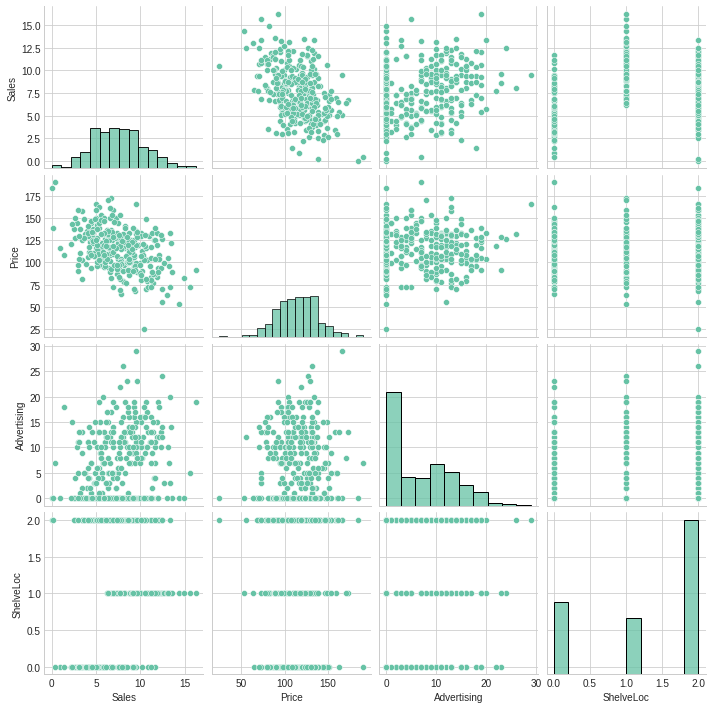

In [224]:
# матричный график разброса с линиями регрессии
sns.pairplot(DF[['Sales', 'Price', 'Advertising', 'ShelveLoc']])
plt.show()

Судя по этим графикам:  
* `ShelveLoc` дискретна, остальные непрерывны;
* Распределение переменных `Sales` и `Price`  стремится к нормальному;
* Из всех объясняющих переменных нет нормально распределенных;

Наблюдаемые закономерности могут объясняться влиянием одной или нескольких из фиктивных объясняющих переменных. Построим график, раскрасив точки цветом в зависимости от качества стеллажа. 

# **ShelveLoc_Good**

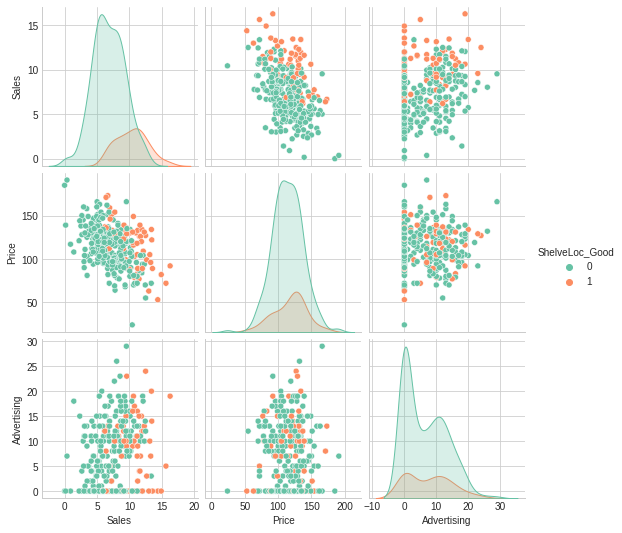

In [225]:
# матричный график разброса с цветом по полу
sns.pairplot(DF[['Sales', 'Price', 'Advertising', 'ShelveLoc_Good']],
            hue='ShelveLoc_Good')

plt.show()

# **ShelveLoc_Medium**

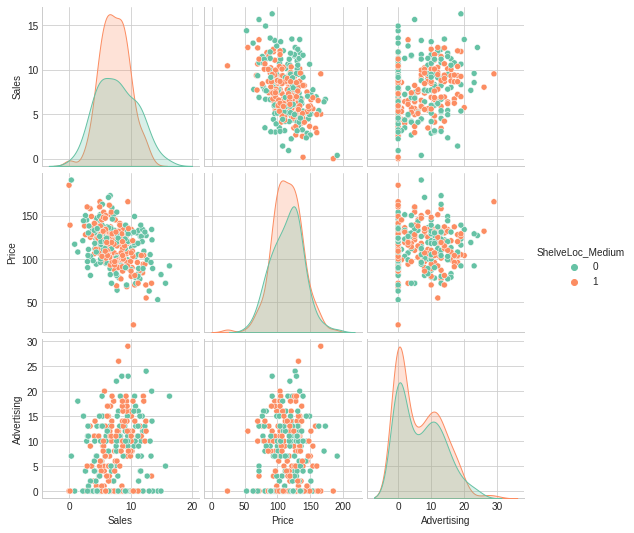

In [226]:
sns.pairplot(DF[['Sales', 'Price', 'Advertising', 'ShelveLoc_Medium']],
            hue='ShelveLoc_Medium')

plt.show()

# **ShelveLoc**

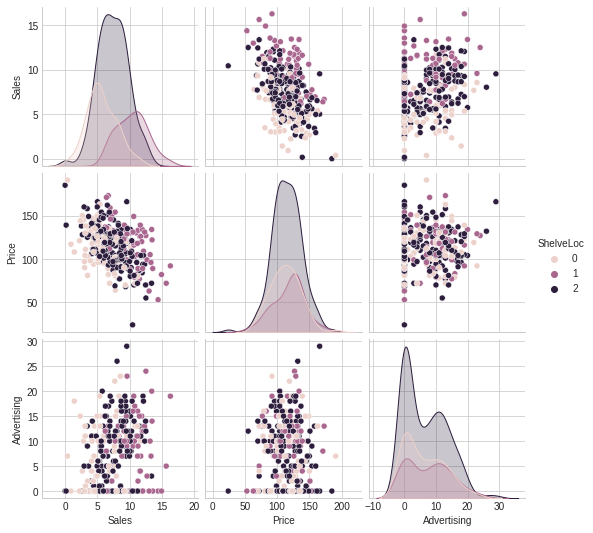

In [227]:
sns.pairplot(DF[['Sales', 'Price', 'Advertising', 'ShelveLoc']],
            hue='ShelveLoc')

plt.show()

Посмотрим на корреляционные матрицы непрерывных переменных фрейма. 

In [228]:
# корреляционная матрица по всем наблюдениям
corr_mat = DF[['Sales', 'Price', 'Advertising', 'ShelveLoc']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,Sales,Price,Advertising,ShelveLoc
Sales,1.00,-0.44,0.27,0.16
Price,-0.44,1.00,0.05,0.03
Advertising,0.27,0.05,1.00,0.00
ShelveLoc,0.16,0.03,0.00,1.00


In [229]:
# корреляционная матрица по классу хороший стеллаж
corr_mat = DF.loc[DF['ShelveLoc_Good'] == 1][['Sales', 'Price', 'Advertising']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,Sales,Price,Advertising
Sales,1.00,-0.63,0.20
Price,-0.63,1.00,0.06
Advertising,0.20,0.06,1.00


In [230]:
# корреляционная матрица по классу не хороший стеллаж
corr_mat = DF.loc[DF['ShelveLoc_Good'] == 0][['Sales', 'Price', 'Advertising']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,Sales,Price,Advertising
Sales,1.00,-0.51,0.29
Price,-0.51,1.00,0.04
Advertising,0.29,0.04,1.00


In [231]:
# корреляционная матрица по классу средний стеллаж
corr_mat = DF.loc[DF['ShelveLoc_Medium'] == 1][['Sales', 'Price', 'Advertising']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,Sales,Price,Advertising
Sales,1.00,-0.59,0.33
Price,-0.59,1.00,0.02
Advertising,0.33,0.02,1.00


In [232]:
# корреляционная матрица по классу не средний стеллаж
corr_mat = DF.loc[DF['ShelveLoc_Medium'] == 0][['Sales', 'Price', 'Advertising']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,Sales,Price,Advertising
Sales,1.00,-0.32,0.22
Price,-0.32,1.00,0.08
Advertising,0.22,0.08,1.00


Вывод: Как можно заметить по корреляционным матрица, объем продаж среднего стеллажа и хорошего несильно отличается (дельту качества компинсируют рекламой), но в случае прироста качества, зависимость продаж от бюджета рекламы на 13% меньше, а дельта ценообразования при повышенном качестве увеличивается на ~ 20%.



### Логарифмируем зависимую переменную  

Важным допущением линейной регрессии является нормальность зависимой переменной. Чтобы добиться нормального распределения, используют логарифмирование либо преобразование Бокса-Кокса. В этой лабораторной остановимся на логарифмировании.   

In [233]:
# логарифмируем зависимую переменную
DF['Sales']+=0.000001
DF['log_Sales'] = np.log(DF['Sales'])

# описательные статистики для непрерывных показателей
DF[['log_Sales', 'Sales', 'Price', 'Advertising']].describe()

,log_Sales,Sales,Price,Advertising
count,320.000000,320.000000,320.000000,320.000000
mean,1.882662,7.525407,114.671875,6.653125
std,1.005892,2.836775,23.400195,6.594977
min,-13.814511,0.000001,24.000000,0.000000
25%,1.689172,5.415001,99.000000,0.000000
50%,2.007543,7.445001,116.000000,5.500000
75%,2.236444,9.360001,130.250000,12.000000
max,2.789323,16.270001,191.000000,29.000000


Проведём формальные тесты на нормальность.  

In [234]:
# тестируем на нормальность
for col in ['Sales', 'log_Sales']:
    stat, p = shapiro(DF[col])
    print(col, 'Statistics=%.2f, p=%.4f' % (stat, p))
    # интерпретация
    alpha = 0.05
    if p > alpha:
        print('Распределение нормально (H0 не отклоняется)\n')
    else:
        print('Распределение не нормально (H0 отклоняется)\n')

Sales Statistics=0.99, p=0.3251
Распределение нормально (H0 не отклоняется)

log_Sales Statistics=0.34, p=0.0000
Распределение не нормально (H0 отклоняется)



Логарифмирование меняет взаимосвязи между переменными.   

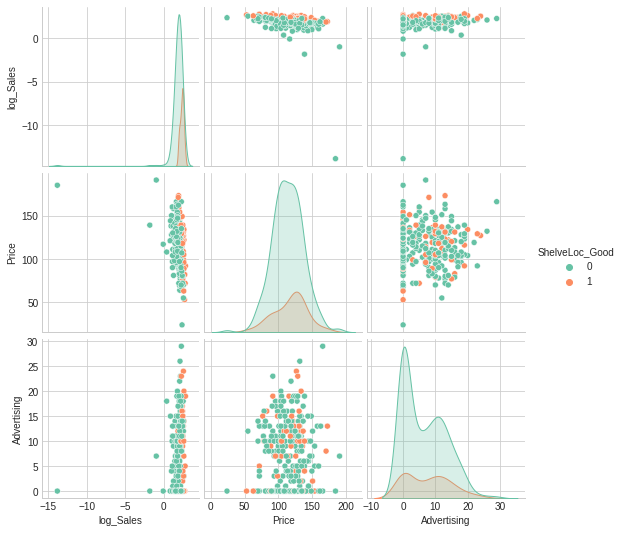

In [235]:
# матричный график разброса с цветом по ShelveLoc_Good
sns.pairplot(DF[['log_Sales', 'Price', 'Advertising', 'ShelveLoc_Good']], hue='ShelveLoc_Good')
plt.show()

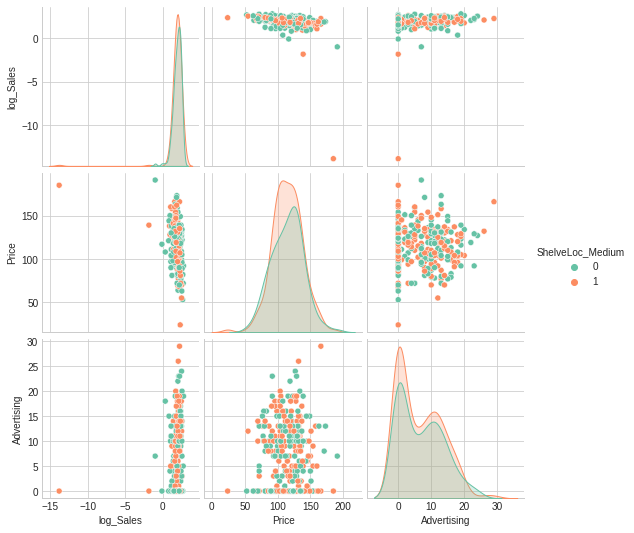

In [236]:
# матричный график разброса с цветом по ShelveLoc_Medium
sns.pairplot(DF[['log_Sales', 'Price', 'Advertising', 'ShelveLoc_Medium']], hue='ShelveLoc_Medium')
plt.show()

In [237]:
# корреляционная матрица по классу не курильщиков
corr_mat = DF.loc[DF['ShelveLoc_Good'] == 1][['log_Sales', 'Price', 'Advertising']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_Sales,Price,Advertising
log_Sales,1.00,-0.63,0.21
Price,-0.63,1.00,0.06
Advertising,0.21,0.06,1.00


In [238]:
# корреляционная матрица по классу курильщиков
corr_mat = DF.loc[DF['ShelveLoc_Good'] == 0][['log_Sales', 'Price', 'Advertising']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_Sales,Price,Advertising
log_Sales,1.00,-0.37,0.15
Price,-0.37,1.00,0.04
Advertising,0.15,0.04,1.00


In [239]:
# корреляционная матрица по классу курильщиков
corr_mat = DF.loc[DF['ShelveLoc_Medium'] == 1][['log_Sales', 'Price', 'Advertising']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_Sales,Price,Advertising
log_Sales,1.00,-0.37,0.16
Price,-0.37,1.00,0.02
Advertising,0.16,0.02,1.00


In [240]:
corr_mat = DF.loc[DF['ShelveLoc_Medium'] == 0][['log_Sales', 'Price', 'Advertising']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_Sales,Price,Advertising
log_Sales,1.00,-0.33,0.17
Price,-0.33,1.00,0.08
Advertising,0.17,0.08,1.00


## Строим модели регрессии

### Спецификация моделей  
По итогам предварительного анализа данных можно предложить следующие спецификации линейных регрессионных моделей:  

1. `fit_lm_1`: $\hat{Sales} = \hat{\beta_0} + \hat{\beta_1} \cdot {ShelveLoc_Good} + \hat{\beta_2} \cdot Price + \hat{\beta_3} \cdot Advertising$
1. `fit_lm_2`: $\hat{Sales} = \hat{\beta_0} + \hat{\beta_1} \cdot ShelveLoc_Good + \hat{\beta_2} \cdot Price \cdot ShelveLoc_Good + \hat{\beta_3} \cdot Advertising$
1. `fit_lm_3`: $\hat{Sales} = \hat{\beta_0} + \hat{\beta_1} \cdot ShelveLoc_Good + \hat{\beta_2} \cdot Advertising \cdot ShelveLoc_Good + \hat{\beta_3} \cdot Price$
1. `fit_lm_4`: $\hat{Sales} = \hat{\beta_0} + \hat{\beta_1} \cdot ShelveLoc_Good + \hat{\beta_2} \cdot Advertising \cdot ShelveLoc_Good + \hat{\beta_3} \cdot Price \cdot ShelveLoc_Good$

1. `fit_lm_1_log`: то же, что `fit_lm_1`, но для зависимой $\hat{log\_Sales}$  
1. `fit_lm_2_log`: то же, что `fit_lm_2`, но для зависимой $\hat{log\_Sales}$
1. `fit_lm_3_log`: то же, что `fit_lm_3`, но для зависимой $\hat{log\_Sales}$
1. `fit_lm_4_log`: то же, что `fit_lm_4`, но для зависимой $\hat{log\_Sales}$

Кроме того, добавим в сравнение модели зависимости `Sales` и `log_Sales` от всех объясняющих переменных: `fit_lm_0` и `fit_lm_0_log` соответственно.  


### Обучение и интерпретация  

Создаём матрицы значений объясняющих переменных ( $X$ ) и вектора значений зависимой ( $y$ ) для всех моделей.  

In [241]:
# данные для моделей 1, 5
df1 = DF[['Sales', 'ShelveLoc_Medium', 'Price', 'Advertising']]

# данные для моделей 2, 6
df2 = DF[['Sales', 'ShelveLoc_Medium', 'Price', 'Advertising']]
df2.loc[:, 'Price_ShelveLoc_Medium'] = df2.loc[:, 'Price'] * df2.loc[:, 'ShelveLoc_Medium']
df2 = df2.drop(['Price'], axis=1)

# данные для моделей 3, 7
df3 = DF[['Sales', 'ShelveLoc_Medium', 'Price', 'Advertising']]
df3.loc[:, 'Advertising_ShelveLoc_Medium'] = df3.loc[:, 'Advertising'] * df3.loc[:, 'ShelveLoc_Medium']
df3 = df3.drop(['Advertising'], axis=1)

# данные для моделей 4, 8
df4 = DF[['Sales', 'ShelveLoc_Medium', 'Price', 'Advertising']]
df4.loc[:, 'Advertising_ShelveLoc_Medium'] = df4.loc[:, 'Advertising'] * df4.loc[:, 'ShelveLoc_Medium']
df4.loc[:, 'Price_ShelveLoc_Medium'] = df4.loc[:, 'Price'] * df4.loc[:, 'ShelveLoc_Medium']
df4 = df4.drop(['Advertising', 'Price'], axis=1)

# данные для моделей 9, 10
df0 = DF.drop(['log_Sales', 'ShelveLoc'], axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [242]:
# проверка результатов
df4.head(5)

,Sales,ShelveLoc_Medium,Advertising_ShelveLoc_Medium,Price_ShelveLoc_Medium
332,5.740001,1,20,104
111,6.620001,1,12,151
352,13.440001,0,0,0
205,5.680001,1,1,132
56,11.910001,1,0,84


Построим модели от всех объясняющих переменных на всех наблюдениях `DF`, чтобы проинтерпретировать параметры. В модели для зависимой переменной `charges` интерпретация стандартная:  

1. Константа – базовый уровень зависимой переменной, когда все объясняющие равны 0.  
2. Коэффициент при объясняющей переменной $X$ показывает, на сколько своих единиц измерения изменится $Y$, если $X$ увеличится на одну свою единицу измерения.  

In [243]:
lm = skl_lm.LinearRegression()

# модель со всеми объясняющими, y
X = df0.drop(['Sales'], axis=1)
y = df0.Sales.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)
print('модель fit_lm_0:\n', 
      'константа ', np.around(fit_lm_0.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0.coef_, 3))

модель fit_lm_0:
 константа  [11.658] 
 объясняющие  ['Price', 'Advertising', 'ShelveLoc_Good', 'ShelveLoc_Medium'] 
 коэффициенты  [[-0.059  0.108  4.81   1.786]]


In [244]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_0.predict(X)
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
np.sqrt(MSE)

array([1.79633057])

С интерпретацией модели на логарифме $Y$ дела обстоят сложнее:  
1. Константу сначала надо экспоненциировать, далее интерпретировать как для обычной модели регрессии.  
1. Коэффициент при $X$ нужно экспоненциировать, затем вычесть из получившегося числа 1, затем умножить на 100. Результат показывает, на сколько процентов изменится (увеличится, если коэффициент положительный, и уменьшится, если отрицательный) зависимая переменная, если $X$ увеличится на одну свою единицу измерения.  

In [245]:
# модель со всеми объясняющими, y_log
X = df0.drop(['Sales'], axis=1)
y = np.log(df0.Sales).values.reshape(-1, 1)
fit_lm_0_log = lm.fit(X, y)
print('модель fit_lm_0_log:\n', 
      'константа ', np.around(fit_lm_0_log.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0_log.coef_, 3))

модель fit_lm_0_log:
 константа  [3.2] 
 объясняющие  ['Price', 'Advertising', 'ShelveLoc_Good', 'ShelveLoc_Medium'] 
 коэффициенты  [[-0.015  0.024  0.724  0.245]]


In [246]:
# пересчёт коэффициентов для их интерпретации
np.around((np.exp(fit_lm_0_log.coef_) - 1) * 100, 1)

array([[ -1.5,   2.4, 106.3,  27.8]])

In [247]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_0_log.predict(X)
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
np.sqrt(MSE_log)

array([2.49622333])

In [248]:
print('MSE_train модели для Sales меньше MSE_train',
     'модели для log(Sales) в ', np.around(MSE_log / MSE, 1), 'раз')

MSE_train модели для Sales меньше MSE_train модели для log(Sales) в  [1.9] раз


### Оценка точности

#### LOOCV  

Сделаем перекрёстную проверку точности моделей по одному наблюдению.  

In [249]:
# LeaveOneOut CV
loo = LeaveOneOut()

# модели для y
scores = list()
# таймер
tic = time.perf_counter()
for df in [df0, df1, df2, df3, df4] :
    loo.get_n_splits(df)
    X = df.drop(['Sales'], axis=1)
    y = df.Sales
    score = cross_val_score(lm, X, y, cv=loo,
                           scoring='neg_mean_squared_error').mean()    
    scores.append(score)

# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 4.79 секунд


In [250]:
df0.shape

(320, 5)

In [251]:
# модели для y_log
scores_log = list()
# таймер
tic = time.perf_counter()
for df in [df0, df1, df2, df3, df4] :
    loo.get_n_splits(df)
    X = df.drop(['Sales'], axis=1)
    y = np.log(df.Sales)
    score = cross_val_score(lm, X, y, cv=loo, n_jobs=1,
                            scoring='neg_mean_squared_error').mean()
    scores_log.append(score)

# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 4.76 секунд


Сравним ошибки для моделей на исходных значениях `charges` с ошибками моделей на логарифме.  

In [252]:
scores

[-3.3322616304287878,
 -5.956127624226764,
 -6.5067034169019,
 -6.242507429156546,
 -6.718948986744978]

In [253]:
[np.around(-x, 2) for x in scores]

[3.33, 5.96, 6.51, 6.24, 6.72]

In [254]:
[np.around(-x, 3) for x in scores_log]

[0.867, 0.926, 0.955, 0.932, 0.959]

Определим самые точные модели отдельно на `charges` и на `log_charges`.  

In [255]:
# самая точная на Sales
fits = ['fit_lm_0', 'fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_loocv =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_0 :
MSE_loocv = 3.0


In [256]:
# самая точная на log(Sales)
fits = ['fit_lm_0_log', 'fit_lm_1_log', 'fit_lm_2_log', 
        'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
      fits[scores_log.index(max(scores_log))], 
      ':\nMSE_loocv =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_0_log :
MSE_loocv = 0.867


#### Перекрёстная проверка по блокам    

Теоретически этот метод менее затратен, чем LOOCV. Проверим на наших моделях.   

In [257]:
# Перекрёстная проверка по 10 блокам
folds = 10

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)

# модели для y
scores = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0, df1, df2, df3, df4] :
    X = df.drop(['Sales'], axis=1)
    y = df.Sales
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_10,
                            scoring='neg_mean_squared_error').mean()
    scores.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.18 секунд


In [258]:
# Перекрёстная проверка по 10 блокам
folds = 10

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)

# модели для y
scores_log = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0, df1, df2, df3, df4] :
    X = df.drop(['Sales'], axis=1)
    y = np.log(df.Sales)
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_10,
                            scoring='neg_mean_squared_error').mean()
    scores_log.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.16 секунд


In [259]:
scores

[-3.3962739046052284,
 -6.0691470056037415,
 -6.505880617146602,
 -6.258303224065796,
 -6.706914894769897]

In [260]:
# самая точная на Sales
fits = ['fit_lm_0', 'fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_kf10 =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_0 :
MSE_kf10 = 3.0


In [261]:
# самая точная на log(Sales)
fits = ['fit_lm_0_log', 'fit_lm_1_log', 'fit_lm_2_log', 
        'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
      fits[scores_log.index(max(scores_log))], 
      ':\nMSE_kf10 =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_0_log :
MSE_kf10 = 0.878


Можно убедиться, что оценка MSE методом перекрёстной проверки по 10 блокам даёт результаты, практически идентичные методу LOOCV. При этом скорость у первого метода при нашем кол-ве наблюдениях выше на два порядка.

Самой точной среди моделей для `Sales` оказалась `fit_lm_0`, а среди моделей для `log_Sales` – `fit_lm_0_log`. Оценим точность прогноза по этим моделям на отложенные наблюдения.   

In [262]:
# прогноз по fit_lm_0
#  модель на всех обучающих наблюдениях
X = df0.drop(['Sales'], axis=1)
y = df0.Sales.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = DF_predict[['Sales']].values.reshape(-1, 1)
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict
X = X.drop(['Sales', 'ShelveLoc'], axis=1)
#  прогнозы
y_pred = fit_lm_0.predict(X)

# ошибка
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_0 на отложенных наблюдениях = %.2f' % MSE)

MSE модели fit_lm_0 на отложенных наблюдениях = 2.68


In [263]:
# прогноз по fit_lm_log_0
# модель
#df0 = DF.drop(['log_sales', 'ShelveLoc'], axis=1)
X = df0.drop(['Sales'], axis=1)
y = np.log(df0.Sales).values.reshape(-1, 1)
fit_lm_0_log = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = np.log(DF_predict[['Sales']].values.reshape(-1, 1))
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict.drop(['Sales', 'ShelveLoc'], axis=1)

#  прогнозы
y_pred = fit_lm_0_log.predict(X)

# ошибка
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_0_log на отложенных наблюдениях = %.2f' % MSE_log)

MSE модели fit_lm_0_log на отложенных наблюдениях = 7.24


In [264]:
np.sqrt(MSE_log) / np.mean(DF_predict[['Sales']]) * 100

Sales    36.454438
dtype: float64

In [265]:
np.sqrt(MSE) / np.mean(DF_predict[['Sales']]) * 100

Sales    22.180018
dtype: float64

Очевидно, на выборке для прогноза точнее модель `fit_lm_0`, которая включает в себя все переменные, кроме `ShelveLoc`.

In [266]:
X = df3.drop(['Sales'], axis=1)
y = df3.Sales.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)

print('модель fit_lm_0:\n', 
      'константа ', np.around(fit_lm_0.intercept_, 3),
      '\n объясняющие ', list(df3.drop(['Sales'], axis=1).columns.values),
      '\n коэффициенты ', np.around(fit_lm_0.coef_, 3))

модель fit_lm_0:
 константа  [13.835] 
 объясняющие  ['ShelveLoc_Medium', 'Price', 'Advertising_ShelveLoc_Medium'] 
 коэффициенты  [[-1.156 -0.053  0.123]]


# **Интерпретация параметров модели**
Y = 13.835 - 1.156 * ShelveLoc_Medium - 0.053 * Price + 0.123 * Advertising_ShelveLoc_Medium



1. Ошибка модели на отложенных наблюдениях составила 22,2% от среднего значения Y
2. Если объясняющие переменные будут равняться нулю, то Y равен константе = 13.835
3. При увеличении ShelveLoc_Medium на единицу, Y **уменьшится на 1.156**. При увеличении Price на единицу, Y **уменьшится на 0.053**. При значении переменной Advertising_ShelveLoc_Medium = 1, Y **увеличится на 0.123**, а при значении равном нулю, **значение Y зависит только от непрерывных переменных**.




# Источники 

1. *James G., Witten D., Hastie T. and Tibshirani R.*  An Introduction to Statistical Learning with Applications in R. URL: [http://www-bcf.usc.edu/~gareth/ISL/ISLR%20First%20Printing.pdf](https://drive.google.com/file/d/15PdWDMf9hkfP8mrCzql_cNiX2eckLDRw/view?usp=sharing)     
1. Рашка С. Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.
1. Interpreting Log Transformations in a Linear Model / virginia.edu. URL: <https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/>  
1. Python Timer Functions: Three Ways to Monitor Your Code / realpython.com. URL: <https://realpython.com/python-timer/>  